# Forward-Forward
[pytorch_forward_forward](https://github.com/mohammadpz/pytorch_forward_forward)

No use Threshold version.

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

import matplotlib.pyplot as plt
import torchvision.transforms as tvtf
from torchvision.datasets import MNIST

from torch.utils.data import DataLoader

from abc import abstractmethod
from tqdm.notebook import tqdm
from uuid import uuid4
from pprint import pprint
from pathlib import Path

In [2]:
def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):
    transform = tvtf.Compose([
        tvtf.ToTensor(),
        tvtf.Normalize((0.1307,), (0.3081,)),
        tvtf.Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        MNIST('./ignore_dir/data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./ignore_dir/data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

def overlay_y_on_x(x, y):
    x_ = x.clone()
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_

In [3]:
class FFModule(nn.Module):
    def __init__(self, layer_train_num_epochs: int):
        super().__init__()
        self.train_num_epochs = layer_train_num_epochs
        self.activation_fn = None
        self.optimizer = None

    @abstractmethod    
    def forward(self, x):
        """
        calc "Goodness" value of input data
        """
        return

    def train(self, positive, negative):
        with tqdm(range(self.train_num_epochs)) as t:

            for i in t:
                goodness_pos = self.forward(positive).pow(2).mean(1)
                goodness_neg = self.forward(negative).pow(2).mean(1)
                loss: torch.Tensor = torch.log(
                    1 + torch.exp(
                        torch.cat([-goodness_pos, goodness_neg])
                    )
                ).mean()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

        return self.forward(positive).detach(), self.forward(negative).detach()

In [4]:
class FFLinear(FFModule):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    layer_train_num_epochs: int
    weight: torch.Tensor

    def __init__(self, in_features: int, out_features: int, layer_train_num_epochs: int = 1000,
                 bias: bool = True, device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FFLinear, self).__init__(layer_train_num_epochs=layer_train_num_epochs)
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.parameter.Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = nn.parameter.Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [5]:
class FFLayer(FFLinear):
    def __init__(self, in_features, out_features, layer_train_num_epochs=100,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, layer_train_num_epochs, bias, device, dtype)
        self.activation_fn = nn.ReLU()
        self.optimizer = opt.Adam(self.parameters(), lr=0.03)

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.activation_fn(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))

In [6]:
class Net(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [FFLayer(dims[d], dims[d + 1], layer_train_num_epochs=500).cuda()]

    def predict(self, x, tmp=False):
        goodness_per_label = []
        for label in range(10):
            h = overlay_y_on_x(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]

        goodness_per_label = torch.cat(goodness_per_label, 1)
        goodness_per_label = F.softmax(goodness_per_label, dim=1)

        if tmp: pprint(list(enumerate(goodness_per_label[0])))
        return goodness_per_label.argmax(1)

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            h_pos, h_neg = layer.train(h_pos, h_neg)

In [7]:
torch.manual_seed(1234)
train_loader, test_loader = MNIST_loaders()

net = Net([784, 512, 256, 64])
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()
x.size(0), y.size(0)

x_pos = overlay_y_on_x(x, y)
rnd = torch.randperm(x.size(0))
x_neg = overlay_y_on_x(x, y[rnd])

In [8]:
net.train(x_pos, x_neg)

print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())

x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.cuda(), y_te.cuda()

print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

train error: 0.09102004766464233
test error: 0.0886000394821167


In [9]:
k = torch.randperm(5000)[0:12]
k, net.predict(x_te[k]), y_te[k]

(tensor([4742,  365,  556, 3026,  147,  132, 1148, 3004, 1689,  120, 3300,  509]),
 tensor([7, 0, 4, 1, 2, 5, 0, 8, 2, 5, 3, 5], device='cuda:0'),
 tensor([7, 0, 4, 1, 2, 5, 0, 2, 2, 5, 3, 5], device='cuda:0'))

[(0, tensor(0.0786, device='cuda:0', grad_fn=<UnbindBackward0>)),
 (1, tensor(0.0719, device='cuda:0', grad_fn=<UnbindBackward0>)),
 (2, tensor(0.1058, device='cuda:0', grad_fn=<UnbindBackward0>)),
 (3, tensor(0.0677, device='cuda:0', grad_fn=<UnbindBackward0>)),
 (4, tensor(0.0672, device='cuda:0', grad_fn=<UnbindBackward0>)),
 (5, tensor(0.0786, device='cuda:0', grad_fn=<UnbindBackward0>)),
 (6, tensor(0.0822, device='cuda:0', grad_fn=<UnbindBackward0>)),
 (7, tensor(0.0671, device='cuda:0', grad_fn=<UnbindBackward0>)),
 (8, tensor(0.3134, device='cuda:0', grad_fn=<UnbindBackward0>)),
 (9, tensor(0.0677, device='cuda:0', grad_fn=<UnbindBackward0>))]
3004 tensor([8], device='cuda:0') tensor(2, device='cuda:0')


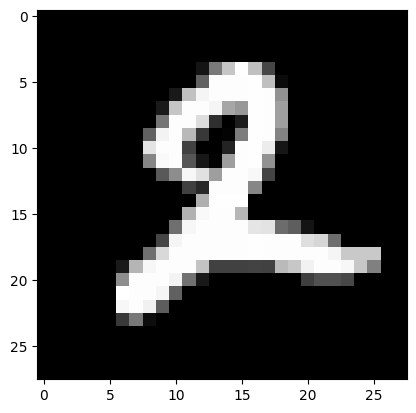

In [10]:
index = 3004# int(torch.randint(0, 5000, (1, )))
print(index, net.predict(x_te[index].unsqueeze(0), tmp=True), y_te[index])
plt.imshow(x_te[index].cpu().reshape((1, 28, 28)).numpy().transpose((1, 2, 0)), cmap="gray")
plt.show()

In [11]:
# def return_default(var, default_value=None):
#     return var or default_value

In [12]:
# class FFModule(nn.Module):
#     __layer_cnt__ = 0
#     __layer_dict__ = dict()
#     def __init__(
#         self, train_num_epochs_in_layer: int,
#         activation_fn = None, optimizer_fn = None, layer_name = None,
#         learning_rate = None,
#         **kwargs
#     ):
#         nn.Module.__init__(self)
#
#         learning_rate = return_default(learning_rate, 0.001)
#         activation_fn = return_default(activation_fn, nn.ReLU)
#         self._optimizer_fn = return_default(optimizer_fn, opt.Adam)
#
#         self.train_num_epochs_in_layer = train_num_epochs_in_layer
#         self.activation_fn = activation_fn()
#         self.optimizer = None
#         self.learning_rate = learning_rate
#
#         self._name = layer_name or str(uuid4())[:8]
#         self._layer_num = FFModule.__layer_cnt__
#
#         FFModule.__layer_cnt__ += 1
#         FFModule.__layer_dict__[self._name] = self
#
#     def init(self):
#         self.init_optimizer()
#
#     def init_optimizer(self):
#         self.optimizer = self._optimizer_fn(self.parameters(), lr=self.learning_rate)
#
#     @abstractmethod
#     def forward(self, x):
#         return
#
#     def calc_loss(self, positive_goodness, negative_goodness) -> torch.Tensor:
#         return torch.log(
#             1 + torch.exp(
#                 torch.cat(
#                     [-positive_goodness, negative_goodness]
#                 )
#             )
#         ).mean()
#
#     def train(self, positive_sample, negative_sample):
#         with tqdm(range(self.train_num_epochs_in_layer)) as t:
#             for i in t:
#                 t.set_description(f"[training layer {self.__layer_num__}:'{self.name}'][epoch: {i:d4}]")
#                 loss = self.calc_loss(
#                     self.forward(positive_sample).pow(2).mean(1),
#                     self.forward(negative_sample).pow(2).mean(1),
#                 )
#                 self.optimizer.zero_grad()
#                 loss.backward()
#
#                 self.optimizer.step()
#                 t.update()
#
#         return self.forward(positive_sample).detach(), self.forward(negative_sample).detach()

In [13]:
# class FFConv2d(FFModule, nn.Conv2d):
#     def __init__(
#         self, in_channels: int, out_channels: int,
#         kernel_size, stride = 1, padding = 0,
#         dilation = 1, groups: int = 1, bias: bool = True,
#         padding_mode: str = 'zeros', device = None, dtype = None,
#         train_num_epochs_in_layer: int = 1000,
#         activation_fn = None, optimizer_fn = None, learning_rate = None,
#         layer_name = None,
#         **kwargs
#     ) -> None:
#         nn.Conv2d.__init__(
#             self, in_features=in_features, out_features=out_features,
#             bias=bias, device=device, dtype=dtype
#         )
#         FFModule.__init__(
#             self, train_num_epochs_in_layer=train_num_epochs_in_layer,
#             activation_fn=activation_fn, optimizer_fn=optimizer_fn, layer_name=layer_name,
#             learning_rate=learning_rate
#         )

In [14]:
# class FFLayer(FFLinear):
#     def __init__(self):
#         super().__init__(784, 10)
#         self.activation_fn = nn.ReLU()
#         self.optimizer = opt.Adam(self.parameters(), lr=0.03)
#
#         self.init()
#
#     def forward(self, x):
#         x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
#         return self.activation_fn(
#             torch.mm(x_direction, self.weight.T) +
#             self.bias.unsqueeze(0))

In [15]:
# FFLayer()